In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re  # For removing emojis


In [33]:
emails_df = pd.read_csv('/content/combined_data.csv')
emails_df

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...
...,...,...
83443,0,hi given a date how do i get the last date of ...
83444,1,now you can order software on cd or download i...
83445,1,dear valued member canadianpharmacy provides a...
83446,0,subscribe change profile contact us long term ...


In [34]:
# Download NLTK data (tokenizer and stopwords)
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
# Assuming the CSV contains 'label' (1 for spam, 0 for ham) and 'text' (email content)
text_column = 'text'
label_column = 'label'


In [36]:
# Step 1: Remove null values
emails_df.dropna(subset=[text_column], inplace=True) # Changed 'df' to 'emails_df'

In [37]:
emails_df.isnull().sum()

,0
label,0
text,0


In [38]:
# Step 2: Remove extra spaces from the email body
emails_df[text_column] = emails_df[text_column].str.strip() # Changed 'df' to 'emails_df'

In [39]:
# Step 3: Function to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [40]:
# Apply emoji removal to the text column
emails_df[text_column] = emails_df[text_column].apply(lambda x: remove_emojis(str(x))) # Changed 'df' to 'emails_df'

In [41]:
# Step 4: Remove stopwords
stop_words = set(stopwords.words('english'))


In [42]:
# Function to tokenize and remove stopwords
def process_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and keep meaningful tokens
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
    return filtered_tokens


In [43]:
# Apply the processing to the text column
emails_df['tokenized_text'] = emails_df[text_column].apply(lambda x: process_text(str(x))) # Changed 'df' to 'emails_df'

In [44]:
# Step 5: Remove empty rows after tokenization
emails_df = emails_df[emails_df['tokenized_text'].str.len() > 0] # Changed 'df' to 'emails_df'

In [45]:
# Display the cleaned and tokenized data
emails_df[[label_column, text_column, 'tokenized_text']].head() # Changed 'df' to 'emails_df'

,label,text,tokenized_text
0,1,ounce feather bowl hummingbird opec moment ala...,"[ounce, feather, bowl, hummingbird, opec, mome..."
1,1,wulvob get your medircations online qnb ikud v...,"[wulvob, get, medircations, online, qnb, ikud,..."
2,0,computer connection from cnn com wednesday esc...,"[computer, connection, cnn, com, wednesday, es..."
3,1,university degree obtain a prosperous future m...,"[university, degree, obtain, prosperous, futur..."
4,0,thanks for all your answers guys i know i shou...,"[thanks, answers, guys, know, checked, rsync, ..."


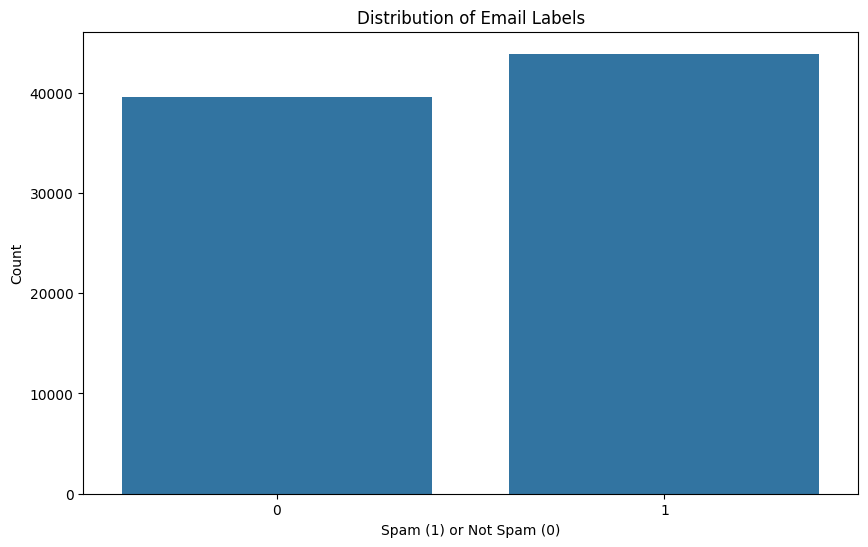

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=emails_df)
plt.title('Distribution of Email Labels')
plt.xlabel('Spam (1) or Not Spam (0)')
plt.ylabel('Count')
plt.show()

In [47]:
x = emails_df.drop(columns=['label'])
y = emails_df['label']

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    emails_df['tokenized_text'], emails_df['label'], test_size=0.2, random_state=42
)

# Assuming 'tokenized_text' is the column with tokenized text
vectorizer = TfidfVectorizer()

# Join the tokens back into a single string for each document
X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

# Fit the vectorizer on the joined strings and transform the training and testing data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [51]:
y_pred_nb = nb_classifier.predict(X_test)

In [52]:
y_pred_nb

array([1, 0, 1, ..., 0, 0, 0])

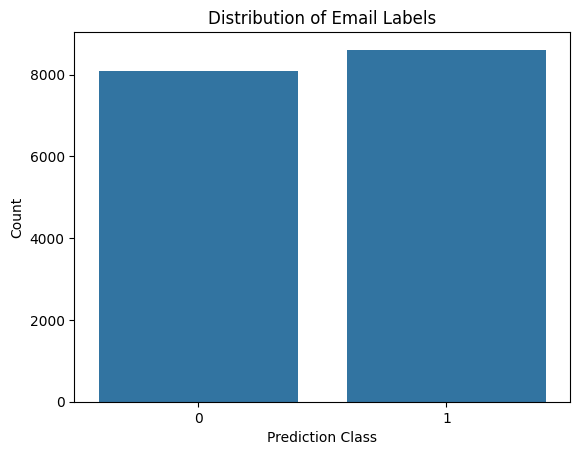

In [53]:
sns.countplot(x=y_pred_nb)
plt.title('Distribution of Email Labels')
plt.xlabel('Prediction Class')
plt.ylabel('Count')
plt.show()

In [54]:
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_classification_report = classification_report(y_test, y_pred_nb)

print("Naive Bayes Classifier:")
print("Accuracy:", nb_accuracy)
print('Classification Report:\n', nb_classification_report)


Naive Bayes Classifier:
Accuracy: 0.9739854942156686
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      7865
           1       0.99      0.96      0.98      8818

    accuracy                           0.97     16683
   macro avg       0.97      0.97      0.97     16683
weighted avg       0.97      0.97      0.97     16683



In [55]:
svm_classifier = SVC(kernel='linear', random_state = 42)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [56]:
y_pred_svm = svm_classifier.predict(X_test)

In [57]:
y_pred_svm

array([1, 1, 1, ..., 0, 0, 0])

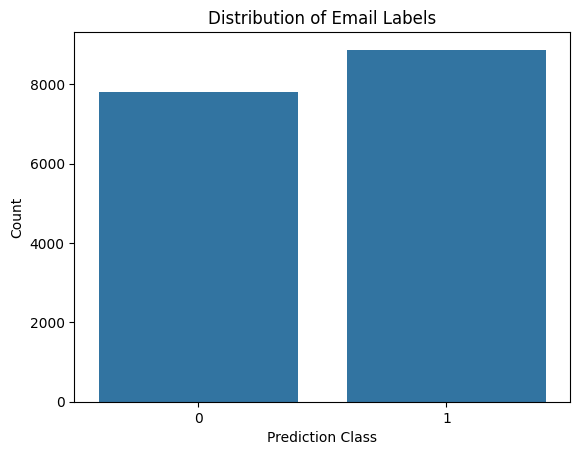

In [58]:
sns.countplot(x=y_pred_svm)
plt.title('Distribution of Email Labels')
plt.xlabel('Prediction Class')
plt.ylabel('Count')
plt.show()

In [59]:
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_classification_report = classification_report(y_test, y_pred_svm)

print("\nSupport Vector Machine Classifier:")
print("Accuracy:", svm_accuracy)
print('Classification Report:\n', svm_classification_report)


Support Vector Machine Classifier:
Accuracy: 0.9901696337589163
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7865
           1       0.99      0.99      0.99      8818

    accuracy                           0.99     16683
   macro avg       0.99      0.99      0.99     16683
weighted avg       0.99      0.99      0.99     16683



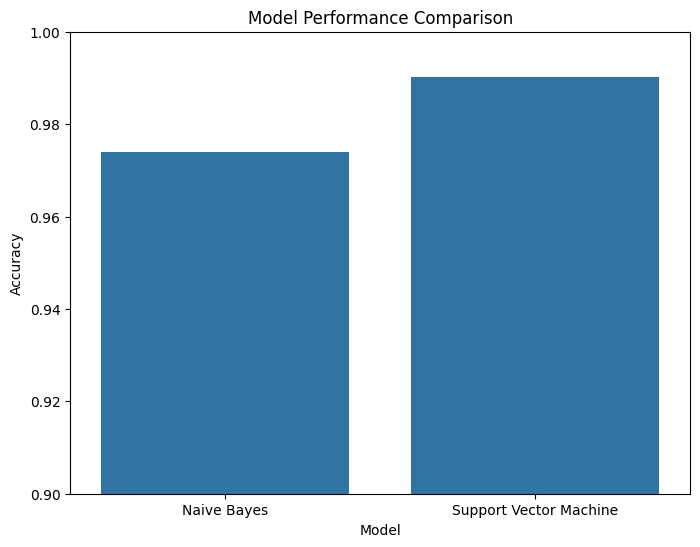

In [60]:
model_performance = pd.DataFrame({
    'Model': ['Naive Bayes', 'Support Vector Machine'],
    'Accuracy': [nb_accuracy, svm_accuracy]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=model_performance)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)  # Set the y-axis limits to 0 to 1
plt.show()